<a href="https://colab.research.google.com/github/baeksumin/k-project/blob/main/data_preprocessing/optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#talib 설치
!wget -q http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 2>&1 > /dev/null
!tar xvzf ta-lib-0.4.0-src.tar.gz 2>&1 > /dev/null

import os

os.chdir('ta-lib')  

!./configure --prefix=/usr 2>&1 > /dev/null
!make 2>&1 > /dev/null
!make install 2>&1 > /dev/null

os.chdir('../')

!pip install TA-Lib 2>&1 > /dev/null

./configure: line 4354: /usr/bin/file: No such file or directory
libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')
libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')
libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')
libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')
ar: `u' modifier ignored since `D' is the default (see `U')
gen_code.c: In function ‘printFuncHeaderDoc’:
gen_code.c:3456:4: warning: format not a string literal and no format arguments [-Wformat-security]
    fprintf( out, prefix );
    ^~~~~~~


In [3]:
import re
import json
import pytz
import requests
import pandas as pd
from io import BytesIO
from datetime import datetime 
from datetime import timedelta
import pickle
from google.colab import drive
# import talib
import numpy as np

drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/[Shared]K-Project/data/'

Mounted at /content/drive


In [4]:
# 저장된 삼성전자(KR7005930003) 데이터 가져오기

with open(data_path + 'initial_data1.json',"r") as json_file:
    json_data = json.load(json_file) 

df = pd.read_json(json_data['KR7005930003'], orient ='index') 
samsung = df.transpose()
samsung

,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,EPS,PER,BPS,PBR,DPS,DVD_YLD,ACC_TRDVOL
0,2021/11/17,005930,삼성전자,"70,700","71,300","71,600","70,600","422,063,626,285,000","3,841",18.41,"39,406",1.79,"2,994",4.23,None
1,2021/11/16,005930,삼성전자,"71,300","71,500","72,000","71,300","425,645,495,815,000","3,841",18.56,"39,406",1.81,"2,994",4.20,None
2,2021/11/15,005930,삼성전자,"71,400","71,700","71,900","70,900","426,242,474,070,000","3,841",18.59,"39,406",1.81,"2,994",4.19,None
3,2021/11/12,005930,삼성전자,"70,600","70,200","70,900","69,900","421,466,648,030,000","3,841",18.38,"39,406",1.79,"2,994",4.24,"10,087,450"
4,2021/11/11,005930,삼성전자,"69,900","69,900","70,000","69,600","417,287,800,245,000","3,841",18.20,"39,406",1.77,"2,994",4.28,"11,489,122"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6719,1995/05/08,005930,삼성전자,"121,000","122,000","122,000","120,500","6,578,606,045,000",-,-,-,-,-,-,"91,810"
6720,1995/05/06,005930,삼성전자,"122,000","122,000","123,500","122,000","6,632,974,690,000",-,-,-,-,-,-,"47,440"
6721,1995/05/04,005930,삼성전자,"122,500","124,000","124,500","122,000","6,660,159,012,500",-,-,-,-,-,-,"175,590"
6722,1995/05/03,005930,삼성전자,"123,500","119,500","126,500","119,500","6,714,527,657,500",-,-,-,-,-,-,"382,980"


In [5]:
#시간순 재정렬
samsung = samsung.sort_values(by=['TRD_DD'])
samsung.reset_index(drop=True,inplace=True)
samsung['TRD_DD']=pd.to_datetime(samsung['TRD_DD']) #datetime변환

In [6]:
# 일년치 데이터만 추출
samsung01 = samsung.copy()
# samsung01 = samsung01[(samsung01['TRD_DD']>='2020-10-21') & (samsung01['TRD_DD']<='2021-10-20')]
samsung01 = samsung01.reset_index(drop = True)
samsung01

,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,EPS,PER,BPS,PBR,DPS,DVD_YLD,ACC_TRDVOL
0,1995-05-02,005930,삼성전자,"119,500","121,000","121,000","118,500","6,497,053,077,500",-,-,-,-,-,-,"139,560"
1,1995-05-03,005930,삼성전자,"123,500","119,500","126,500","119,500","6,714,527,657,500",-,-,-,-,-,-,"382,980"
2,1995-05-04,005930,삼성전자,"122,500","124,000","124,500","122,000","6,660,159,012,500",-,-,-,-,-,-,"175,590"
3,1995-05-06,005930,삼성전자,"122,000","122,000","123,500","122,000","6,632,974,690,000",-,-,-,-,-,-,"47,440"
4,1995-05-08,005930,삼성전자,"121,000","122,000","122,000","120,500","6,578,606,045,000",-,-,-,-,-,-,"91,810"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6719,2021-11-11,005930,삼성전자,"69,900","69,900","70,000","69,600","417,287,800,245,000","3,841",18.20,"39,406",1.77,"2,994",4.28,"11,489,122"
6720,2021-11-12,005930,삼성전자,"70,600","70,200","70,900","69,900","421,466,648,030,000","3,841",18.38,"39,406",1.79,"2,994",4.24,"10,087,450"
6721,2021-11-15,005930,삼성전자,"71,400","71,700","71,900","70,900","426,242,474,070,000","3,841",18.59,"39,406",1.81,"2,994",4.19,None
6722,2021-11-16,005930,삼성전자,"71,300","71,500","72,000","71,300","425,645,495,815,000","3,841",18.56,"39,406",1.81,"2,994",4.20,None


In [8]:
#인풋 데이터 모양 맞춰주기(backtest에 들어갈 데이터 모양)
samsung_bt = samsung01[['TRD_DD','TDD_OPNPRC','TDD_HGPRC','TDD_LWPRC','TDD_CLSPRC', 'ACC_TRDVOL']]
samsung_bt['TRD_DD'] = pd.to_datetime(samsung_bt['TRD_DD'])
samsung_bt.rename(columns={'TRD_DD':'Date', 'TDD_OPNPRC':'Open', 'TDD_HGPRC':'High','TDD_LWPRC':'Low','TDD_CLSPRC':'Close', 'ACC_TRDVOL':'Volume'}, inplace=True)
samsung_bt.set_index('Date',drop=True,inplace=True)
samsung_bt['OpenInterest'] =  np.zeros(6724, dtype=int)
samsung_bt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

,Open,High,Low,Close,Volume,OpenInterest
Date,,,,,,
1995-05-02,"121,000","121,000","118,500","119,500","139,560",0
1995-05-03,"119,500","126,500","119,500","123,500","382,980",0
1995-05-04,"124,000","124,500","122,000","122,500","175,590",0
1995-05-06,"122,000","123,500","122,000","122,000","47,440",0
1995-05-08,"122,000","122,000","120,500","121,000","91,810",0
...,...,...,...,...,...,...
2021-11-11,"69,900","70,000","69,600","69,900","11,489,122",0
2021-11-12,"70,200","70,900","69,900","70,600","10,087,450",0
2021-11-15,"71,700","71,900","70,900","71,400",None,0


In [9]:
#데이터프레임 콤마(,) 제거 그리고 타입 소수로 변환
samsung_bt['Open'] = samsung_bt['Open'].str.replace(',','').astype('float')
samsung_bt['High'] = samsung_bt['High'].str.replace(',','').astype('float')
samsung_bt['Low'] = samsung_bt['Low'].str.replace(',','').astype('float')
samsung_bt['Close'] = samsung_bt['Close'].str.replace(',','').astype('float')
samsung_bt['Volume'] = samsung_bt['Volume'].str.replace(',','').astype('float')
samsung_bt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,Open,High,Low,Close,Volume,OpenInterest
Date,,,,,,
1995-05-02,121000.0,121000.0,118500.0,119500.0,139560.0,0
1995-05-03,119500.0,126500.0,119500.0,123500.0,382980.0,0
1995-05-04,124000.0,124500.0,122000.0,122500.0,175590.0,0
1995-05-06,122000.0,123500.0,122000.0,122000.0,47440.0,0
1995-05-08,122000.0,122000.0,120500.0,121000.0,91810.0,0
...,...,...,...,...,...,...
2021-11-11,69900.0,70000.0,69600.0,69900.0,11489122.0,0
2021-11-12,70200.0,70900.0,69900.0,70600.0,10087450.0,0
2021-11-15,71700.0,71900.0,70900.0,71400.0,NaN,0


In [10]:
samsung_bt = samsung_bt.replace(0, -1)
samsung_bt

,Open,High,Low,Close,Volume,OpenInterest
Date,,,,,,
1995-05-02,121000.0,121000.0,118500.0,119500.0,139560.0,-1
1995-05-03,119500.0,126500.0,119500.0,123500.0,382980.0,-1
1995-05-04,124000.0,124500.0,122000.0,122500.0,175590.0,-1
1995-05-06,122000.0,123500.0,122000.0,122000.0,47440.0,-1
1995-05-08,122000.0,122000.0,120500.0,121000.0,91810.0,-1
...,...,...,...,...,...,...
2021-11-11,69900.0,70000.0,69600.0,69900.0,11489122.0,-1
2021-11-12,70200.0,70900.0,69900.0,70600.0,10087450.0,-1
2021-11-15,71700.0,71900.0,70900.0,71400.0,NaN,-1


In [11]:
!pip install backtrader

     |████████████████████████████████| 410 kB 5.2 MB/s 


# GA

In [12]:
df = samsung_bt.copy()
df = df.drop(['OpenInterest'], axis = 1)
df

,Open,High,Low,Close,Volume
Date,,,,,
1995-05-02,121000.0,121000.0,118500.0,119500.0,139560.0
1995-05-03,119500.0,126500.0,119500.0,123500.0,382980.0
1995-05-04,124000.0,124500.0,122000.0,122500.0,175590.0
1995-05-06,122000.0,123500.0,122000.0,122000.0,47440.0
1995-05-08,122000.0,122000.0,120500.0,121000.0,91810.0
...,...,...,...,...,...
2021-11-11,69900.0,70000.0,69600.0,69900.0,11489122.0
2021-11-12,70200.0,70900.0,69900.0,70600.0,10087450.0
2021-11-15,71700.0,71900.0,70900.0,71400.0,NaN


In [13]:
import backtrader as bt

class SMAStrategy(bt.Strategy):
    # list of parameters which are configurable for the strategy
    # params = dict(fast_period=12, slow_period=26, signal_period=9)
    params = dict(sma_short = 50, sma_long = 200)

    def __init__(self):

        # self.fast_ma = bt.indicators.EMA(self.data.close, period=self.p.fast_period)
        # self.slow_ma = bt.indicators.EMA(self.data.close, period=self.p.slow_period)
        # self.macd_line = self.fast_ma - self.slow_ma
        # self.signal_line = bt.indicators.EMA(self.macd_line, period=self.p.signal_period)
        # self.macd_crossover = bt.indicators.CrossOver(self.macd_line, self.signal_line)

        self.sma_short = bt.indicators.Mean(self.data.close, period = self.p.sma_short) # 단기이동평균선
        self.sma_long = bt.indicators.Mean(self.data.close, period = self.p.sma_long) # 장기이동평균선

    def next(self):

        # if self.macd_crossover > 0:
        #     self.buy()  # enter long position
        # elif self.macd_crossover < 0:
        #     self.close()  # close long position

        first_cross = 0 
        if self.sma_short < self.sma_long and first_cross == 0:
            self.sell()
            first_cross = 1
        elif self.sma_short > self.sma_long and first_cross == 1:
            self.buy()
            first_cross = 0
        else:
            pass 

In [14]:
TICKER = "SAMSUNG"
# STRATEGY_PARAMS = dict(fast_period=12, slow_period=26, signal_period=9)
STRATEGY_PARAMS = dict(sma_short = 50, sma_long = 200)

def run_backtest(plot=True, **strategy_params):

    cerebro = bt.Cerebro()
    cerebro.adddata(
        bt.feeds.PandasData(dataname=df, name=TICKER)
    )

    # Remember to set it high enough or the strategy may not
    # be able to trade because of short of cash
    cerebro.broker.setcash(10000.0) # 초기투자비용

    # Print out the starting conditions
    print(f"Starting Portfolio Value: {cerebro.broker.getvalue():,.2f}")

    # Although we have defined some default params in the strategy,
    # we can override it by passing in keyword arguments here.
    cerebro.addstrategy(SMAStrategy, **strategy_params)

    cerebro.addobserver(bt.observers.Trades)
    cerebro.addobserver(bt.observers.DrawDown)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio)

    # Let's say that we have 0.25% slippage and commission per trade,
    # that is 0.5% in total for a round trip.
    cerebro.broker.setcommission(commission=0.0025, margin=False) # 수수료 계산

    # Run over everything
    strats = cerebro.run()

    print(f"Final Portfolio Value:    {cerebro.broker.getvalue():,.2f}")

    if plot:
        figure = cerebro.plot(volume=False, width=25, height=25)[0][0] 
        figure.savefig('example_sma.png') # 코랩에서 시각화하는 방법

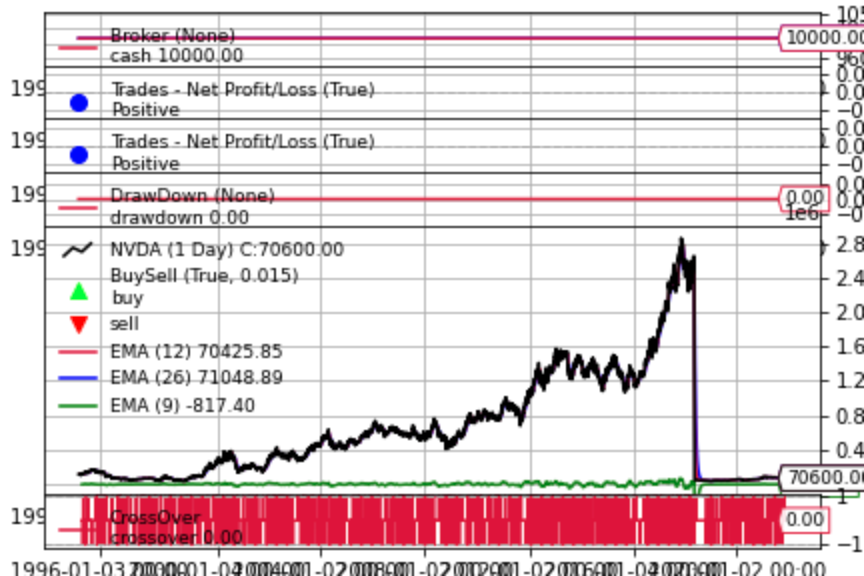

In [15]:
run_backtest(plot=True, **STRATEGY_PARAMS)

Starting Portfolio Value: 10,000.00
Final Portfolio Value:    1,156,047,227.26


<IPython.core.display.Javascript object>

In [16]:
!pip install deap

     |████████████████████████████████| 160 kB 4.9 MB/s 


# fitness -> profit / (max_dd if max_dd > 0 else 1)

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import trange
import time
import random
from deap import base
from deap import creator
from deap import tools


# fix the seed so that we will get the same results
# feel free to change it or comment out the line
random.seed(1)

# GA parameters
# PARAM_NAMES = ["fast_period", "slow_period", "signal_period"]
PARAM_NAMES = ["sma_short", "sma_long"]
NGEN = 20
NPOP = 100
CXPB = 0.5
MUTPB = 0.3

data = bt.feeds.PandasData(dataname=df)


def evaluate(individual, plot=False, log=False):

    # convert list of parameter values into dictionary of kwargs
    strategy_params = {k: v for k, v in zip(PARAM_NAMES, individual)}

    # fast moving average by definition cannot be slower than the slow one
    if strategy_params["sma_short"] >= strategy_params["sma_long"]: # 단기이평선은 장기이평선보다 길 수 없다.
        return [-np.inf]

    # by setting stdstats to False, backtrader will not store the changes in
    # statistics like number of trades, buys & sells, etc.
    cerebro = bt.Cerebro(stdstats=False)
    cerebro.adddata(data)

    # Remember to set it high enough or the strategy may not
    # be able to trade because of short of cash
    initial_capital = 10_000.0
    cerebro.broker.setcash(initial_capital)

    # Pass in the genes of the individual as kwargs
    cerebro.addstrategy(SMAStrategy, **strategy_params)

    # This is needed for calculating our fitness score
    cerebro.addanalyzer(bt.analyzers.DrawDown)

    # Let's say that we have 0.25% slippage and commission per trade,
    # that is 0.5% in total for a round trip.
    cerebro.broker.setcommission(commission=0.0025, margin=False)

    # Run over everything
    strats = cerebro.run()

    profit = cerebro.broker.getvalue() - initial_capital
    max_dd = strats[0].analyzers.drawdown.get_analysis()["max"]["moneydown"]
    fitness = profit / (max_dd if max_dd > 0 else 1)
    # fitness = 1 / profit # 수익률의 역수

    if log:
        print(f"Starting Portfolio Value: {initial_capital:,.2f}")
        print(f"Final Portfolio Value:    {cerebro.broker.getvalue():,.2f}")
        print(f"Total Profit:             {profit:,.2f}")
        print(f"Maximum Drawdown:         {max_dd:,.2f}")
        print(f"Profit / Max DD:          {fitness}")

    if plot:
        cerebro.plot()

    return [fitness]


# our fitness score is supposed to be maximised and there is only 1 objective
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# our individual is a list of genes, with the fitness score the higher the better
creator.create("Individual", list, fitness=creator.FitnessMax)

# register some handy functions for calling
toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(NPOP), NPOP)
# crossover strategy
toolbox.register("mate", tools.cxUniform, indpb=CXPB)
# mutation strategy
toolbox.register("mutate", tools.mutUniformInt, low=1, up=151, indpb=0.2)
# selection strategy
toolbox.register("select", tools.selTournament, tournsize=3)
# fitness function
toolbox.register("evaluate", evaluate)

# definition of an individual & a population
# toolbox.register("attr_fast_period", random.randint, 1, 51)
# toolbox.register("attr_slow_period", random.randint, 10, 151)
# toolbox.register("attr_signal_period", random.randint, 1, 101)
toolbox.register('attr_sma_short', random.randint, 31, 81) # default: 50
toolbox.register('attr_sma_long', random.randint, 181, 231) # default: 200

toolbox.register(
    "individual",
    tools.initCycle,
    creator.Individual,
    (
        # toolbox.attr_fast_period,
        # toolbox.attr_slow_period,
        # toolbox.attr_signal_period,
        toolbox.attr_sma_short,
        toolbox.attr_sma_long,
    ),
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

mean = np.ndarray(NGEN)
best = np.ndarray(NGEN)
hall_of_fame = tools.HallOfFame(maxsize = 5)

t = time.perf_counter()
pop = toolbox.population(n=NPOP)
for g in trange(NGEN):
    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # Apply mutation on the offspring
    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # The population is entirely replaced by the offspring
    pop[:] = offspring
    hall_of_fame.update(pop)
    print(
        "\nHALL OF FAME:\n"
        + "\n".join(
            [
                f"    {_}: {ind}, Fitness: {ind.fitness.values[0]}"
                for _, ind in enumerate(hall_of_fame)
            ]
        )
    )

    fitnesses = [
        ind.fitness.values[0] for ind in pop if not np.isinf(ind.fitness.values[0])
    ]
    mean[g] = np.mean(fitnesses)
    best[g] = np.max(fitnesses)
    # best[g] = np.min(fitnesses) # fitness가 작은게 좋은 값

end_t = time.perf_counter()
print(f"Time Elapsed: {end_t - t:,.2f}")

fig, ax = plt.subplots(sharex=True, figsize=(16, 9))

sns.lineplot(x=range(NGEN), y=mean, ax=ax, label="Average Fitness Score")
sns.lineplot(x=range(NGEN), y=best, ax=ax, label="Best Fitness Score")
ax.set_title("Fitness Score")
ax.set_xticks(range(NGEN))
ax.set_xlabel("Iteration")

plt.tight_layout()
# plt.show()
plt.savefig('example_sma2.png')

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
  5%|▌         | 1/20 [05:50<1:51:01, 350.62s/it]


HALL OF FAME:
    0: [73, 125], Fitness: 0.22688661473392785
    1: [77, 213], Fitness: 0.22225335392239917
    2: [72, 205], Fitness: 0.22172863053826908
    3: [78, 213], Fitness: 0.22169820158033732
    4: [80, 216], Fitness: 0.22154434038546894


 10%|█         | 2/20 [09:33<1:22:33, 275.21s/it]


HALL OF FAME:
    0: [68, 99], Fitness: 0.2316175690125177
    1: [73, 125], Fitness: 0.22688661473392785
    2: [66, 144], Fitness: 0.22398256698176325
    3: [77, 213], Fitness: 0.22225335392239917
    4: [73, 206], Fitness: 0.22212160815488266


 15%|█▌        | 3/20 [13:22<1:12:05, 254.42s/it]


HALL OF FAME:
    0: [68, 99], Fitness: 0.2316175690125177
    1: [68, 109], Fitness: 0.22856852692937885
    2: [56, 125], Fitness: 0.227331756309754
    3: [73, 125], Fitness: 0.22688661473392785
    4: [73, 136], Fitness: 0.22561968622624679


 20%|██        | 4/20 [16:47<1:02:39, 234.94s/it]


HALL OF FAME:
    0: [73, 88], Fitness: 0.2365722717839114
    1: [78, 99], Fitness: 0.2364590735340872
    2: [73, 95], Fitness: 0.23571684033294538
    3: [77, 99], Fitness: 0.23557238456889598
    4: [80, 99], Fitness: 0.23538893264412572


 25%|██▌       | 5/20 [20:23<56:59, 227.97s/it]  


HALL OF FAME:
    0: [73, 88], Fitness: 0.2365722717839114
    1: [78, 99], Fitness: 0.2364590735340872
    2: [73, 93], Fitness: 0.23642926197827685
    3: [80, 83], Fitness: 0.23600855895257808
    4: [73, 95], Fitness: 0.23571684033294538


 30%|███       | 6/20 [23:48<51:24, 220.34s/it]


HALL OF FAME:
    0: [73, 83], Fitness: 0.2387620214172338
    1: [73, 88], Fitness: 0.2365722717839114
    2: [78, 99], Fitness: 0.2364590735340872
    3: [73, 93], Fitness: 0.23642926197827685
    4: [80, 83], Fitness: 0.23600855895257808


 35%|███▌      | 7/20 [27:39<48:28, 223.69s/it]


HALL OF FAME:
    0: [73, 83], Fitness: 0.2387620214172338
    1: [78, 83], Fitness: 0.23720040662292938
    2: [73, 88], Fitness: 0.2365722717839114
    3: [78, 99], Fitness: 0.2364590735340872
    4: [73, 93], Fitness: 0.23642926197827685


 40%|████      | 8/20 [31:01<43:21, 216.78s/it]


HALL OF FAME:
    0: [64, 83], Fitness: 0.23895794463346284
    1: [73, 83], Fitness: 0.2387620214172338
    2: [77, 83], Fitness: 0.23791409237888886
    3: [78, 83], Fitness: 0.23720040662292938
    4: [73, 88], Fitness: 0.2365722717839114


 45%|████▌     | 9/20 [34:16<38:29, 209.97s/it]


HALL OF FAME:
    0: [64, 83], Fitness: 0.23895794463346284
    1: [73, 83], Fitness: 0.2387620214172338
    2: [77, 83], Fitness: 0.23791409237888886
    3: [78, 84], Fitness: 0.2378687999486135
    4: [78, 83], Fitness: 0.23720040662292938


 50%|█████     | 10/20 [38:23<36:54, 221.43s/it]


HALL OF FAME:
    0: [64, 83], Fitness: 0.23895794463346284
    1: [73, 83], Fitness: 0.2387620214172338
    2: [77, 83], Fitness: 0.23791409237888886
    3: [78, 84], Fitness: 0.2378687999486135
    4: [78, 83], Fitness: 0.23720040662292938


 55%|█████▌    | 11/20 [42:00<33:01, 220.19s/it]


HALL OF FAME:
    0: [63, 83], Fitness: 0.23923369424923074
    1: [64, 83], Fitness: 0.23895794463346284
    2: [73, 83], Fitness: 0.2387620214172338
    3: [77, 83], Fitness: 0.23791409237888886
    4: [78, 84], Fitness: 0.2378687999486135


 60%|██████    | 12/20 [45:09<28:04, 210.62s/it]


HALL OF FAME:
    0: [63, 83], Fitness: 0.23923369424923074
    1: [64, 83], Fitness: 0.23895794463346284
    2: [64, 84], Fitness: 0.23884426178167673
    3: [73, 83], Fitness: 0.2387620214172338
    4: [77, 83], Fitness: 0.23791409237888886


 65%|██████▌   | 13/20 [48:52<24:59, 214.19s/it]


HALL OF FAME:
    0: [64, 74], Fitness: 0.2501974694758958
    1: [5, 83], Fitness: 0.23950323105842233
    2: [63, 83], Fitness: 0.23923369424923074
    3: [58, 83], Fitness: 0.23900228446820987
    4: [55, 83], Fitness: 0.23895996211529016


 70%|███████   | 14/20 [52:19<21:13, 212.22s/it]


HALL OF FAME:
    0: [64, 74], Fitness: 0.2501974694758958
    1: [5, 83], Fitness: 0.23950323105842233
    2: [62, 83], Fitness: 0.23923527733327968
    3: [63, 83], Fitness: 0.23923369424923074
    4: [7, 83], Fitness: 0.23920943099982606


 75%|███████▌  | 15/20 [56:05<18:01, 216.32s/it]


HALL OF FAME:
    0: [63, 75], Fitness: 0.25025280257637716
    1: [64, 74], Fitness: 0.2501974694758958
    2: [5, 83], Fitness: 0.23950323105842233
    3: [62, 83], Fitness: 0.23923527733327968
    4: [63, 83], Fitness: 0.23923369424923074


 80%|████████  | 16/20 [59:44<14:28, 217.11s/it]


HALL OF FAME:
    0: [5, 33], Fitness: 0.25592804321546214
    1: [63, 74], Fitness: 0.2508221894290568
    2: [63, 75], Fitness: 0.25025280257637716
    3: [64, 74], Fitness: 0.2501974694758958
    4: [5, 74], Fitness: 0.24148164710086145


 85%|████████▌ | 17/20 [1:04:04<11:29, 229.91s/it]


HALL OF FAME:
    0: [5, 33], Fitness: 0.25592804321546214
    1: [62, 74], Fitness: 0.25139397948829767
    2: [63, 74], Fitness: 0.2508221894290568
    3: [63, 75], Fitness: 0.25025280257637716
    4: [64, 74], Fitness: 0.2501974694758958


 90%|█████████ | 18/20 [1:07:43<07:33, 226.78s/it]


HALL OF FAME:
    0: [5, 33], Fitness: 0.25592804321546214
    1: [62, 74], Fitness: 0.25139397948829767
    2: [63, 74], Fitness: 0.2508221894290568
    3: [63, 75], Fitness: 0.25025280257637716
    4: [64, 74], Fitness: 0.2501974694758958


 95%|█████████▌| 19/20 [1:11:29<03:46, 226.60s/it]


HALL OF FAME:
    0: [5, 12], Fitness: 0.26611234040054543
    1: [5, 33], Fitness: 0.25592804321546214
    2: [62, 74], Fitness: 0.25139397948829767
    3: [63, 74], Fitness: 0.2508221894290568
    4: [63, 75], Fitness: 0.25025280257637716


100%|██████████| 20/20 [1:14:18<00:00, 222.92s/it]


HALL OF FAME:
    0: [5, 12], Fitness: 0.26611234040054543
    1: [4, 33], Fitness: 0.25691467008576174
    2: [5, 33], Fitness: 0.25592804321546214
    3: [62, 74], Fitness: 0.25139397948829767
    4: [63, 74], Fitness: 0.2508221894290568
Time Elapsed: 4,458.50


<IPython.core.display.Javascript object>

In [41]:
OPTIMISED_STRATEGY_PARAMS = {
    k: v for k, v in zip(PARAM_NAMES, hall_of_fame[0])}
run_backtest(**OPTIMISED_STRATEGY_PARAMS)

Starting Portfolio Value: 10,000.00
Final Portfolio Value:    1,598,775,068.75


In [42]:
print(OPTIMISED_STRATEGY_PARAMS)

{'sma_short': 5, 'sma_long': 12}


In [44]:
print(hall_of_fame)

[[5, 12], [4, 33], [5, 33], [62, 74], [63, 74]]


# fitness -> 1 / profit

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import trange
import time
import random
from deap import base
from deap import creator
from deap import tools


# fix the seed so that we will get the same results
# feel free to change it or comment out the line
random.seed(1)

# GA parameters
# PARAM_NAMES = ["fast_period", "slow_period", "signal_period"]
PARAM_NAMES = ["sma_short", "sma_long"]
NGEN = 20
NPOP = 100
CXPB = 0.5
MUTPB = 0.3

data = bt.feeds.PandasData(dataname=df)


def evaluate(individual, plot=False, log=False):

    # convert list of parameter values into dictionary of kwargs
    strategy_params = {k: v for k, v in zip(PARAM_NAMES, individual)}

    # fast moving average by definition cannot be slower than the slow one
    if strategy_params["sma_short"] >= strategy_params["sma_long"]: # 단기이평선은 장기이평선보다 길 수 없다.
        return [-np.inf]

    # by setting stdstats to False, backtrader will not store the changes in
    # statistics like number of trades, buys & sells, etc.
    cerebro = bt.Cerebro(stdstats=False)
    cerebro.adddata(data)

    # Remember to set it high enough or the strategy may not
    # be able to trade because of short of cash
    initial_capital = 10_000.0
    cerebro.broker.setcash(initial_capital)

    # Pass in the genes of the individual as kwargs
    cerebro.addstrategy(SMAStrategy, **strategy_params)

    # This is needed for calculating our fitness score
    cerebro.addanalyzer(bt.analyzers.DrawDown)

    # Let's say that we have 0.25% slippage and commission per trade,
    # that is 0.5% in total for a round trip.
    cerebro.broker.setcommission(commission=0.0025, margin=False)

    # Run over everything
    strats = cerebro.run()

    profit = cerebro.broker.getvalue() - initial_capital
    max_dd = strats[0].analyzers.drawdown.get_analysis()["max"]["moneydown"]
    # fitness = profit / (max_dd if max_dd > 0 else 1)
    fitness = 1 / profit # 수익률의 역수

    if log:
        print(f"Starting Portfolio Value: {initial_capital:,.2f}")
        print(f"Final Portfolio Value:    {cerebro.broker.getvalue():,.2f}")
        print(f"Total Profit:             {profit:,.2f}")
        print(f"Maximum Drawdown:         {max_dd:,.2f}")
        print(f"Profit / Max DD:          {fitness}")

    if plot:
        cerebro.plot()

    return [fitness]


# our fitness score is supposed to be maximised and there is only 1 objective
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# our individual is a list of genes, with the fitness score the higher the better
creator.create("Individual", list, fitness=creator.FitnessMax)

# register some handy functions for calling
toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(NPOP), NPOP)
# crossover strategy
toolbox.register("mate", tools.cxUniform, indpb=CXPB)
# mutation strategy
toolbox.register("mutate", tools.mutUniformInt, low=1, up=151, indpb=0.2)
# selection strategy
toolbox.register("select", tools.selTournament, tournsize=3)
# fitness function
toolbox.register("evaluate", evaluate)

# definition of an individual & a population
# toolbox.register("attr_fast_period", random.randint, 1, 51)
# toolbox.register("attr_slow_period", random.randint, 10, 151)
# toolbox.register("attr_signal_period", random.randint, 1, 101)
toolbox.register('attr_sma_short', random.randint, 31, 81) # default: 50
toolbox.register('attr_sma_long', random.randint, 181, 231) # default: 200

toolbox.register(
    "individual",
    tools.initCycle,
    creator.Individual,
    (
        # toolbox.attr_fast_period,
        # toolbox.attr_slow_period,
        # toolbox.attr_signal_period,
        toolbox.attr_sma_short,
        toolbox.attr_sma_long,
    ),
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

mean = np.ndarray(NGEN)
best = np.ndarray(NGEN)
hall_of_fame = tools.HallOfFame(maxsize = 5)

t = time.perf_counter()
pop = toolbox.population(n=NPOP)
for g in trange(NGEN):
    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # Apply mutation on the offspring
    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # The population is entirely replaced by the offspring
    pop[:] = offspring
    hall_of_fame.update(pop)
    print(
        "\nHALL OF FAME:\n"
        + "\n".join(
            [
                f"    {_}: {ind}, Fitness: {ind.fitness.values[0]}"
                for _, ind in enumerate(hall_of_fame)
            ]
        )
    )

    fitnesses = [
        ind.fitness.values[0] for ind in pop if not np.isinf(ind.fitness.values[0])
    ]
    mean[g] = np.mean(fitnesses)
    # best[g] = np.max(fitnesses)
    best[g] = np.min(fitnesses) # fitness가 작은게 좋은 값

end_t = time.perf_counter()
print(f"Time Elapsed: {end_t - t:,.2f}")

fig, ax = plt.subplots(sharex=True, figsize=(16, 9))

sns.lineplot(x=range(NGEN), y=mean, ax=ax, label="Average Fitness Score")
sns.lineplot(x=range(NGEN), y=best, ax=ax, label="Best Fitness Score")
ax.set_title("Fitness Score")
ax.set_xticks(range(NGEN))
ax.set_xlabel("Iteration")

plt.tight_layout()
# plt.show()
plt.savefig('example_sma2.png')

  5%|▌         | 1/20 [05:46<1:49:39, 346.29s/it]


HALL OF FAME:
    0: [134, 227], Fitness: 9.231877799271306e-10
    1: [81, 183], Fitness: 9.098397839429269e-10
    2: [113, 219], Fitness: 9.03358729829406e-10
    3: [79, 185], Fitness: 8.962394774193573e-10
    4: [37, 230], Fitness: 8.942231805433204e-10


 10%|█         | 2/20 [09:25<1:21:26, 271.45s/it]


HALL OF FAME:
    0: [109, 195], Fitness: 9.234074667176298e-10
    1: [134, 227], Fitness: 9.231877799271306e-10
    2: [81, 183], Fitness: 9.098397839429269e-10
    3: [113, 219], Fitness: 9.03358729829406e-10
    4: [36, 227], Fitness: 8.978178784262585e-10


 15%|█▌        | 3/20 [13:14<1:11:26, 252.15s/it]


HALL OF FAME:
    0: [134, 214], Fitness: 9.255990006093777e-10
    1: [109, 195], Fitness: 9.234074667176298e-10
    2: [134, 227], Fitness: 9.231877799271306e-10
    3: [134, 208], Fitness: 9.224303142210173e-10
    4: [109, 205], Fitness: 9.12097860346817e-10


 20%|██        | 4/20 [16:39<1:02:15, 233.49s/it]


HALL OF FAME:
    0: [134, 216], Fitness: 9.285252318296678e-10
    1: [134, 217], Fitness: 9.283432439488597e-10
    2: [134, 214], Fitness: 9.255990006093777e-10
    3: [109, 195], Fitness: 9.234074667176298e-10
    4: [134, 227], Fitness: 9.231877799271306e-10


 25%|██▌       | 5/20 [20:14<56:44, 226.99s/it]  


HALL OF FAME:
    0: [134, 216], Fitness: 9.285252318296678e-10
    1: [134, 217], Fitness: 9.283432439488597e-10
    2: [134, 214], Fitness: 9.255990006093777e-10
    3: [109, 195], Fitness: 9.234074667176298e-10
    4: [134, 227], Fitness: 9.231877799271306e-10


 30%|███       | 6/20 [23:36<50:56, 218.30s/it]


HALL OF FAME:
    0: [134, 220], Fitness: 9.305562915318803e-10
    1: [143, 227], Fitness: 9.300941775381454e-10
    2: [134, 216], Fitness: 9.285252318296678e-10
    3: [134, 217], Fitness: 9.283432439488597e-10
    4: [134, 214], Fitness: 9.255990006093777e-10


 35%|███▌      | 7/20 [27:25<48:03, 221.81s/it]


HALL OF FAME:
    0: [134, 220], Fitness: 9.305562915318803e-10
    1: [143, 227], Fitness: 9.300941775381454e-10
    2: [148, 227], Fitness: 9.29290031128312e-10
    3: [134, 216], Fitness: 9.285252318296678e-10
    4: [134, 217], Fitness: 9.283432439488597e-10


 40%|████      | 8/20 [30:39<42:35, 212.92s/it]


HALL OF FAME:
    0: [140, 220], Fitness: 9.312312678327099e-10
    1: [134, 220], Fitness: 9.305562915318803e-10
    2: [143, 227], Fitness: 9.300941775381454e-10
    3: [148, 227], Fitness: 9.29290031128312e-10
    4: [134, 216], Fitness: 9.285252318296678e-10


 45%|████▌     | 9/20 [33:56<38:07, 207.98s/it]


HALL OF FAME:
    0: [140, 220], Fitness: 9.312312678327099e-10
    1: [134, 220], Fitness: 9.305562915318803e-10
    2: [143, 227], Fitness: 9.300941775381454e-10
    3: [148, 227], Fitness: 9.29290031128312e-10
    4: [134, 216], Fitness: 9.285252318296678e-10


 50%|█████     | 10/20 [37:55<36:17, 217.72s/it]


HALL OF FAME:
    0: [143, 220], Fitness: 9.314328346571989e-10
    1: [140, 220], Fitness: 9.312312678327099e-10
    2: [134, 220], Fitness: 9.305562915318803e-10
    3: [143, 227], Fitness: 9.300941775381454e-10
    4: [140, 227], Fitness: 9.298679178961001e-10


 55%|█████▌    | 11/20 [41:38<32:51, 219.09s/it]


HALL OF FAME:
    0: [143, 220], Fitness: 9.314328346571989e-10
    1: [140, 220], Fitness: 9.312312678327099e-10
    2: [134, 220], Fitness: 9.305562915318803e-10
    3: [143, 227], Fitness: 9.300941775381454e-10
    4: [140, 227], Fitness: 9.298679178961001e-10


 60%|██████    | 12/20 [44:31<27:20, 205.09s/it]


HALL OF FAME:
    0: [1, 227], Fitness: 9.384345758501786e-10
    1: [143, 220], Fitness: 9.314328346571989e-10
    2: [140, 220], Fitness: 9.312312678327099e-10
    3: [134, 220], Fitness: 9.305562915318803e-10
    4: [143, 227], Fitness: 9.300941775381454e-10


 65%|██████▌   | 13/20 [48:02<24:08, 207.00s/it]


HALL OF FAME:
    0: [1, 227], Fitness: 9.384345758501786e-10
    1: [1, 220], Fitness: 9.34864600040211e-10
    2: [143, 220], Fitness: 9.314328346571989e-10
    3: [140, 220], Fitness: 9.312312678327099e-10
    4: [134, 220], Fitness: 9.305562915318803e-10


 70%|███████   | 14/20 [51:15<20:17, 202.90s/it]


HALL OF FAME:
    0: [1, 227], Fitness: 9.384345758501786e-10
    1: [1, 220], Fitness: 9.34864600040211e-10
    2: [143, 220], Fitness: 9.314328346571989e-10
    3: [140, 220], Fitness: 9.312312678327099e-10
    4: [134, 220], Fitness: 9.305562915318803e-10


 75%|███████▌  | 15/20 [54:51<17:12, 206.58s/it]


HALL OF FAME:
    0: [1, 227], Fitness: 9.384345758501786e-10
    1: [1, 220], Fitness: 9.34864600040211e-10
    2: [143, 220], Fitness: 9.314328346571989e-10
    3: [140, 220], Fitness: 9.312312678327099e-10
    4: [134, 220], Fitness: 9.305562915318803e-10


 80%|████████  | 16/20 [58:22<13:52, 208.14s/it]


HALL OF FAME:
    0: [1, 227], Fitness: 9.384345758501786e-10
    1: [1, 220], Fitness: 9.34864600040211e-10
    2: [10, 220], Fitness: 9.317772135488344e-10
    3: [143, 220], Fitness: 9.314328346571989e-10
    4: [140, 220], Fitness: 9.312312678327099e-10


 85%|████████▌ | 17/20 [1:02:38<11:07, 222.46s/it]


HALL OF FAME:
    0: [1, 227], Fitness: 9.384345758501786e-10
    1: [1, 220], Fitness: 9.34864600040211e-10
    2: [10, 220], Fitness: 9.317772135488344e-10
    3: [143, 220], Fitness: 9.314328346571989e-10
    4: [140, 220], Fitness: 9.312312678327099e-10


 90%|█████████ | 18/20 [1:06:24<07:27, 223.55s/it]


HALL OF FAME:
    0: [2, 227], Fitness: 9.405712951767857e-10
    1: [1, 227], Fitness: 9.384345758501786e-10
    2: [1, 220], Fitness: 9.34864600040211e-10
    3: [10, 220], Fitness: 9.317772135488344e-10
    4: [143, 220], Fitness: 9.314328346571989e-10


 95%|█████████▌| 19/20 [1:10:22<03:47, 227.81s/it]


HALL OF FAME:
    0: [2, 227], Fitness: 9.405712951767857e-10
    1: [1, 227], Fitness: 9.384345758501786e-10
    2: [1, 220], Fitness: 9.34864600040211e-10
    3: [10, 220], Fitness: 9.317772135488344e-10
    4: [143, 220], Fitness: 9.314328346571989e-10


100%|██████████| 20/20 [1:13:48<00:00, 221.43s/it]


HALL OF FAME:
    0: [2, 227], Fitness: 9.405712951767857e-10
    1: [1, 227], Fitness: 9.384345758501786e-10
    2: [1, 220], Fitness: 9.34864600040211e-10
    3: [10, 220], Fitness: 9.317772135488344e-10
    4: [143, 220], Fitness: 9.314328346571989e-10
Time Elapsed: 4,428.55


<IPython.core.display.Javascript object>

In [18]:
OPTIMISED_STRATEGY_PARAMS = {
    k: v for k, v in zip(PARAM_NAMES, hall_of_fame[0])}
run_backtest(**OPTIMISED_STRATEGY_PARAMS)

Starting Portfolio Value: 10,000.00
Final Portfolio Value:    1,063,193,625.88


In [19]:
print(OPTIMISED_STRATEGY_PARAMS)

{'sma_short': 2, 'sma_long': 227}
